In [38]:
import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

extraction_directory = 'extracted_images/'
y_train = pd.read_csv(extraction_directory + 'y_train.csv', index_col='id')
X_train = pd.read_csv(extraction_directory + 'X_train.csv', index_col='id')

In [39]:
class_distribution = y_train.apply(lambda x: {'Class ' + str(i): x[x == i].count() / X_train.shape[0] for i in range(4)})['y']
for name in class_distribution:
    print(name + ': {:.2%}'.format(class_distribution[name]))

Class 0: 59.21%
Class 1: 8.66%
Class 2: 28.81%
Class 3: 3.32%


In [40]:
X_train_downsampled = X_train.iloc[:,range(0, X_train.shape[1], 2)]

measure_length_downsampled = (-X_train_downsampled.T.isna()).sum().sort_values(ascending=True)

In [41]:
import time

length = measure_length_downsampled.iloc[0]

start = time.time()

X_train1_np = np.zeros((measure_length_downsampled.shape[0], length))
X_train_downsampled_np = X_train_downsampled.to_numpy()

for ind in range(X_train_downsampled.shape[0]):
    first_timestep = (measure_length_downsampled.loc[X_train_downsampled.index[ind]] - length) // 2
    last_timestep = first_timestep + length
    X_train1_np[ind,:] = X_train_downsampled_np[ind,first_timestep:last_timestep]

X_train1 = pd.DataFrame(data=X_train1_np, index=X_train_downsampled.index)

end = time.time()
print(end - start)

0.0730748176574707


In [42]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_transformed_np = scaler.fit_transform(X_train1.to_numpy())

X_train_transformed = pd.DataFrame(data=X_train_transformed_np, index=X_train1.index)

num = 10

fig, axs = plt.subplots(num, 1, figsize=(20, 2*num))

seconds = np.arange(0, length) / 150
x_labels = range(0, int(seconds[-1])+1)

for i, ind in enumerate(measure_length_downsampled.head(num).index):
    ax = axs[i]
    measurements = X_train_transformed.loc[ind].to_numpy()
    ax.plot(seconds, measurements, color='k', label='Class ' + str(y_train.loc[ind]['y']))
    ax.legend(loc='upper right')
    ax.set_xticks(x_labels)
    ax.grid()

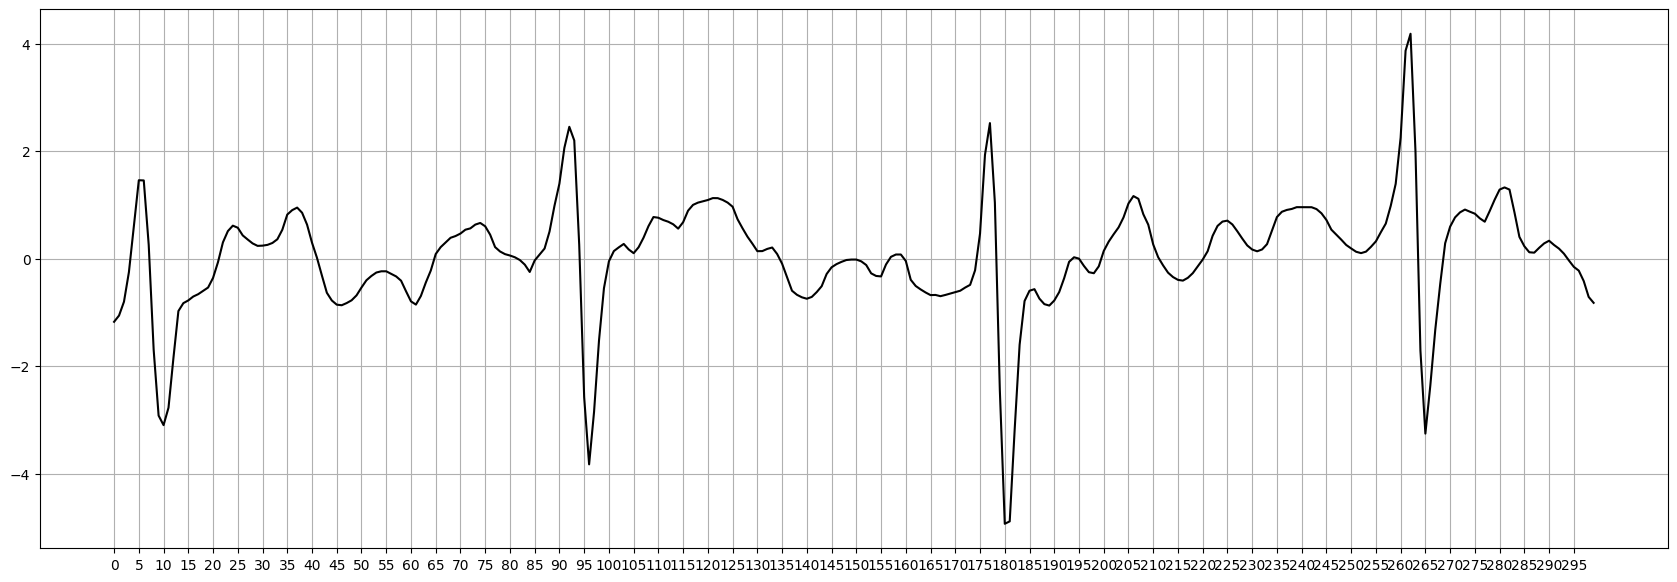

In [43]:
rg = 300

measurements = X_train_transformed.loc[ind].to_numpy()[0:rg]
plt.figure(figsize =(21,7))
plt.plot(measurements, color='k', label='Class ' + str(y_train.loc[ind]['y']))
plt.xticks(range(0,rg,5));
plt.grid()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization, Dropout, Conv1D, Flatten, MaxPooling1D, Input, Concatenate
from keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
import tensorflow as tf

/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
# Convert labels to categorical
y_train_cat_np = to_categorical(y_train.to_numpy())

# Split data
X_train_partial, X_val, y_train_partial, y_val = train_test_split(X_train_transformed_np, y_train_cat_np, test_size=0.2, random_state=23)

In [ ]:
T = X_train_partial.shape[1]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [32, 16, 16, 24, 16, 8, 3]                # number of units in hidden and output layers
M_TRAIN = X_train_partial.shape[0]           # number of training examples (2D)
M_TEST = X_val.shape[0]             # number of test examples (2D),full=X_test.shape[0]
BATCH = M_TRAIN# // 8                          # batch size
EPOCH = 150                          # number of epochs
learning_rate = 5e-3                            # learning rate of the gradient descent
LAMBD = 3e-3                         # lambda in L2 regularizaion
dropout = 0.4                             # dropout rate
dropout_CNN = .5
recurrent_dropout = 0.0                            # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, val_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {1}, epochs = {EPOCH}')
print(f'learning_rate = {learning_rate}, lambda = {LAMBD}, dropout = {dropout}, recurrent_dropout = {recurrent_dropout}')

layers=[32, 16, 16, 24, 16, 8, 3], train_examples=4093, val_examples=1024
batch = 4093, timesteps = 1230, features = 1, epochs = 150
learning_rate = 0.005, lambda = 0.003, dropout = 0.4, recurrent_dropout = 0.0


In [ ]:
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=5, activation='elu', input_shape=(T,1)), )
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Conv1D(filters=16, kernel_size=5, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=16, kernel_size=5, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Conv1D(filters=16, kernel_size=5, activation='elu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())

model.add(Dense(units=32, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=32, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=16, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=4, activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],#, AUC()],#[f1_score],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1,
                             verbose=0, 
                             factor=0.5,
                             min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0, 
                           patience=15000,
                           verbose=1,
                           mode='auto',
                           baseline=0,
                           restore_best_weights=True)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_46 (Conv1D)          (None, 1226, 16)          96        
                                                                 
 batch_normalization_50 (Ba  (None, 1226, 16)          64        
 tchNormalization)                                               
                                                                 
 dropout_28 (Dropout)        (None, 1226, 16)          0         
                                                                 
 conv1d_47 (Conv1D)          (None, 1222, 16)          1296      
                                                                 
 batch_normalization_51 (Ba  (None, 1222, 16)          64        
 tchNormalization)                                               
                                                                 
 dropout_29 (Dropout)        (None, 1222, 16)         

In [ ]:
start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=500,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_val[:M_TEST], y_val[:M_TEST]),
                    shuffle=True,
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 2.0635 - accuracy: 0.2455 - val_loss: 1.5602 - val_accuracy: 0.1357
Epoch 2/500
1/1 [==============================] - 1s 1s/step - loss: 1.9001 - accuracy: 0.2622 - val_loss: 1.7208 - val_accuracy: 0.1895
Epoch 3/500
1/1 [==============================] - 1s 1s/step - loss: 1.8363 - accuracy: 0.2656 - val_loss: 1.8997 - val_accuracy: 0.1855
Epoch 4/500
1/1 [==============================] - 1s 1s/step - loss: 1.7377 - accuracy: 0.2871 - val_loss: 2.0375 - val_accuracy: 0.2021
Epoch 5/500
1/1 [==============================] - 1s 1s/step - loss: 1.6688 - accuracy: 0.3022 - val_loss: 2.0903 - val_accuracy: 0.2041
Epoch 6/500
1/1 [==============================] - 1s 1s/step - loss: 1.6148 - accuracy: 0.2981 - val_loss: 2.1390 - val_accuracy: 0.2285
Epoch 7/500
1/1 [==============================] - 1s 1s/step - loss: 1.5914 - accuracy: 0.3198 - val_loss: 2.1596 - val_accuracy: 0.2373
Epoch 8/500
1/1 [=================

KeyboardInterrupt: 

1/1 [==============================] - 0s 83ms/step - loss: 2.9331 - accuracy: 0.5742 - auc_2: 0.7937
-----------------------------------------------------------------
train accuracy = 99.4869%
test accuracy = 57.4219%


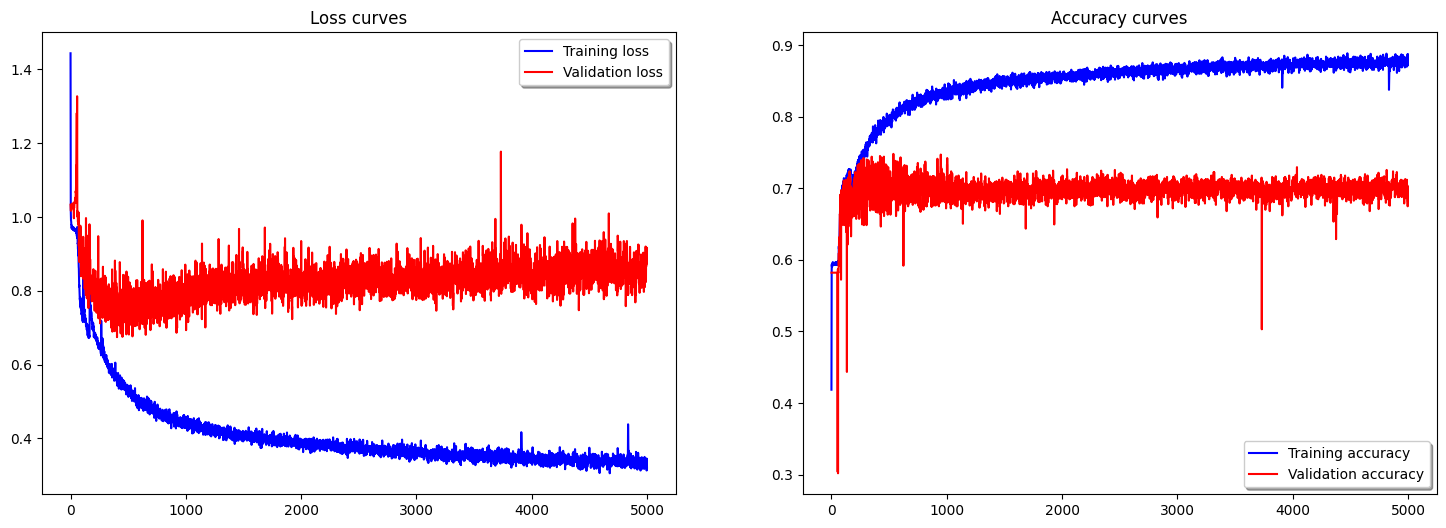

In [ ]:
# Evaluate the model:
train_loss, train_accuracy, _ = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=M_TRAIN,
                                       verbose=1)

test_loss, test_accuracy,_ = model.evaluate(X_val[:M_TEST],
                                     y_val[:M_TEST],
                                     batch_size=M_TEST,
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
# Build the Model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(T,1)))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=13, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=15, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(units=48, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=48, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=4, activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],#, AUC()],#[f1_score],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1,
                             verbose=0, 
                             factor=0.5,
                             min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0, 
                           patience=1500,
                           verbose=1,
                           mode='auto',
                           baseline=0,
                           restore_best_weights=True)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_70 (Conv1D)          (None, 1228, 32)          128       
                                                                 
 dropout_97 (Dropout)        (None, 1228, 32)          0         
                                                                 
 max_pooling1d_46 (MaxPooli  (None, 614, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_71 (Conv1D)          (None, 610, 64)           10304     
                                                                 
 dropout_98 (Dropout)        (None, 610, 64)           0         
                                                                 
 max_pooling1d_47 (MaxPooli  (None, 305, 64)           0         
 ng1D)                                               

In [ ]:
start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=1500,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_val[:M_TEST], y_val[:M_TEST]),
                    shuffle=True,
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

Epoch 1/1500


1/1 [==============================] - 2s 2s/step - loss: 1.3774 - accuracy: 0.5060 - auc_9: 0.7081 - val_loss: 6.4193 - val_accuracy: 0.0703 - val_auc_9: 0.2608
Epoch 2/1500
1/1 [==============================] - 2s 2s/step - loss: 1.3489 - accuracy: 0.5131 - auc_9: 0.7146 - val_loss: 5.9509 - val_accuracy: 0.0889 - val_auc_9: 0.2817
Epoch 3/1500
1/1 [==============================] - 2s 2s/step - loss: 1.3428 - accuracy: 0.5282 - auc_9: 0.7280 - val_loss: 5.5217 - val_accuracy: 0.1182 - val_auc_9: 0.3038
Epoch 4/1500
1/1 [==============================] - 2s 2s/step - loss: 1.3305 - accuracy: 0.5529 - auc_9: 0.7368 - val_loss: 5.1366 - val_accuracy: 0.1396 - val_auc_9: 0.3324
Epoch 5/1500
1/1 [==============================] - 2s 2s/step - loss: 1.2944 - accuracy: 0.5558 - auc_9: 0.7532 - val_loss: 4.7612 - val_accuracy: 0.1787 - val_auc_9: 0.3610
Epoch 6/1500
1/1 [==============================] - 2s 2s/step - loss: 1.2954 - accuracy: 0.5614 - auc_9: 0.7627 - val_loss: 4.4211 - val_

1/1 [==============================] - 0s 140ms/step - loss: 1.0059 - accuracy: 0.7207 - auc_9: 0.9051
-----------------------------------------------------------------
train accuracy = 82.6044%
test accuracy = 72.0703%
train AUC = 0.9692
test AUC = 0.9051


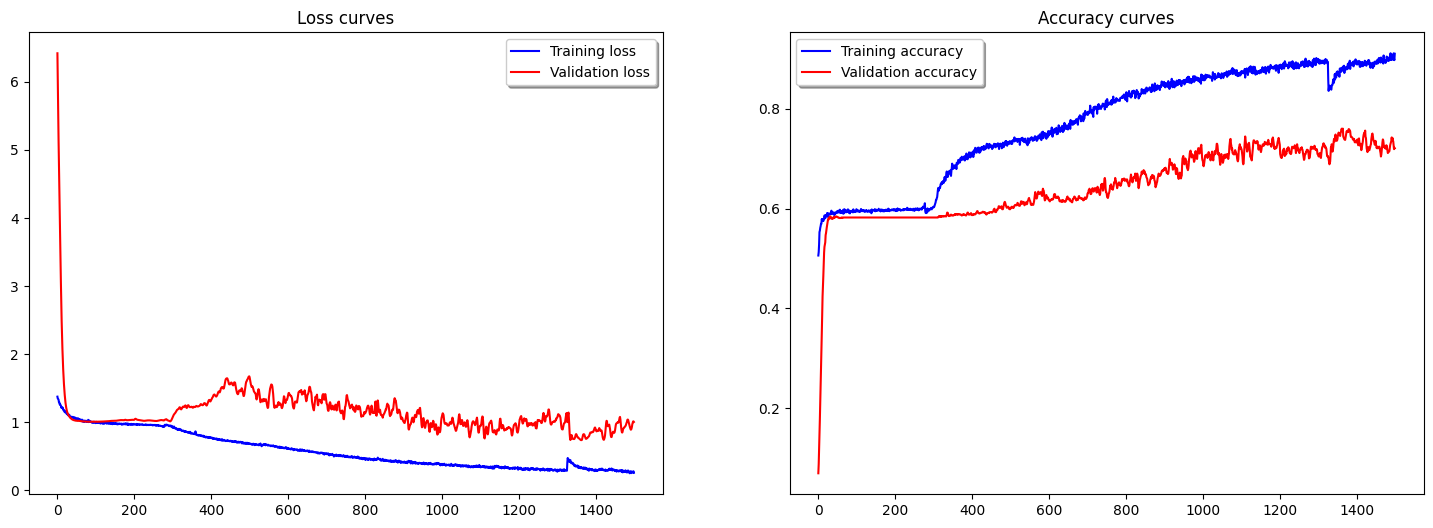

In [ ]:
# Evaluate the model:
train_loss, train_accuracy, train_auc = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=M_TRAIN,
                                       verbose=1)

test_loss, test_accuracy, test_auc = model.evaluate(X_val[:M_TEST],
                                     y_val[:M_TEST],
                                     batch_size=M_TEST,
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')
print(f'train AUC = {round(train_auc, 4)}')
print(f'test AUC = {round(test_auc, 4)}')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
y_pred = model.predict(X_val)
f1_score(y_val, to_categorical(y_pred.argmax(axis=1)), average='micro')

32/32 [==============================] - 0s 9ms/step


0.720703125

In [ ]:
X_test = pd.read_csv(extraction_directory + 'X_test.csv', index_col='id')

X_test_downsampled = X_test.iloc[:,range(0, X_test.shape[1], 2)]
assert X_test_downsampled.shape[1] == X_train_downsampled.shape[1]

measure_length_test_downsampled = (-X_test_downsampled.T.isna()).sum().sort_values(ascending=True)

In [ ]:
start = time.time()

X_test1_np = np.zeros((measure_length_test_downsampled.shape[0], length))
X_test_downsampled_np = X_test_downsampled.to_numpy()

for ind in range(X_test_downsampled.shape[0]):
    first_timestep = (measure_length_test_downsampled.loc[X_test_downsampled.index[ind]] - length) // 2
    last_timestep = first_timestep + length
    X_test1_np[ind,:] = X_test_downsampled_np[ind,first_timestep:last_timestep]

X_test1 = pd.DataFrame(data=X_test1_np, index=X_test_downsampled.index)

X_test_transformed_np = scaler.transform(X_test1)

end = time.time()
print(end - start)

0.05764889717102051


In [ ]:
y_pred = model.predict(X_test_transformed_np)

y_pred_class_np = y_pred.argmax(axis=1)

sol = pd.DataFrame(data={'id': range(y_pred_class_np.shape[0]), 'y': y_pred_class_np})
sol.to_csv('sol_big.csv', columns=['id', 'y'], index = False)

107/107 [==============================] - 1s 9ms/step


(array([2733.,    0.,    0.,  175.,    0.,    0.,  491.,    0.,    0.,
          12.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

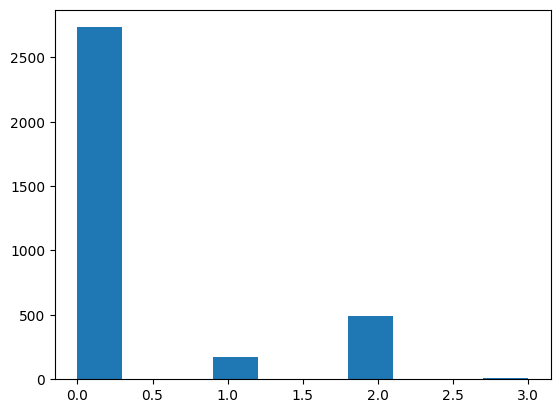

In [ ]:
plt.hist(y_pred_class_np)

In [ ]:
# Build the Model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(T,1)))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=13, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=15, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=4, activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],#, AUC()],#[f1_score],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1,
                             verbose=0, 
                             factor=0.5,
                             min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0, 
                           patience=100000,
                           verbose=1,
                           mode='auto',
                           baseline=0,
                           restore_best_weights=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 1226, 32)          192       
                                                                 
 dropout_9 (Dropout)         (None, 1226, 32)          0         
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 613, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 609, 32)           5152      
                                                                 
 dropout_10 (Dropout)        (None, 609, 32)           0         
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 304, 32)           0         
 g1D)                                                 

In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
BATCH, X_train_partial.shape[0]  

(4093, 4093)

In [ ]:
start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=5000,
                    batch_size=64,
                    validation_split=0.0,
                    validation_data=(X_val[:M_TEST], y_val[:M_TEST]),
                    shuffle=True,
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

Epoch 1/5000
64/64 [==============================] - 3s 36ms/step - loss: 1.4439 - accuracy: 0.4185 - val_loss: 1.0335 - val_accuracy: 0.5820
Epoch 2/5000
64/64 [==============================] - 2s 35ms/step - loss: 1.0824 - accuracy: 0.5636 - val_loss: 1.0216 - val_accuracy: 0.5820
Epoch 3/5000
64/64 [==============================] - 2s 33ms/step - loss: 1.0167 - accuracy: 0.5856 - val_loss: 1.0184 - val_accuracy: 0.5820
Epoch 4/5000
64/64 [==============================] - 2s 34ms/step - loss: 0.9994 - accuracy: 0.5937 - val_loss: 1.0173 - val_accuracy: 0.5820
Epoch 5/5000
64/64 [==============================] - 2s 34ms/step - loss: 0.9905 - accuracy: 0.5908 - val_loss: 1.0183 - val_accuracy: 0.5820
Epoch 6/5000
64/64 [==============================] - 2s 33ms/step - loss: 0.9892 - accuracy: 0.5930 - val_loss: 1.0187 - val_accuracy: 0.5820
Epoch 7/5000
64/64 [==============================] - 2s 33ms/step - loss: 0.9855 - accuracy: 0.5925 - val_loss: 1.0184 - val_accuracy: 0.5820

1/1 [==============================] - 0s 86ms/step - loss: 0.9140 - accuracy: 0.6826
-----------------------------------------------------------------
train accuracy = 73.9311%
test accuracy = 68.2617%


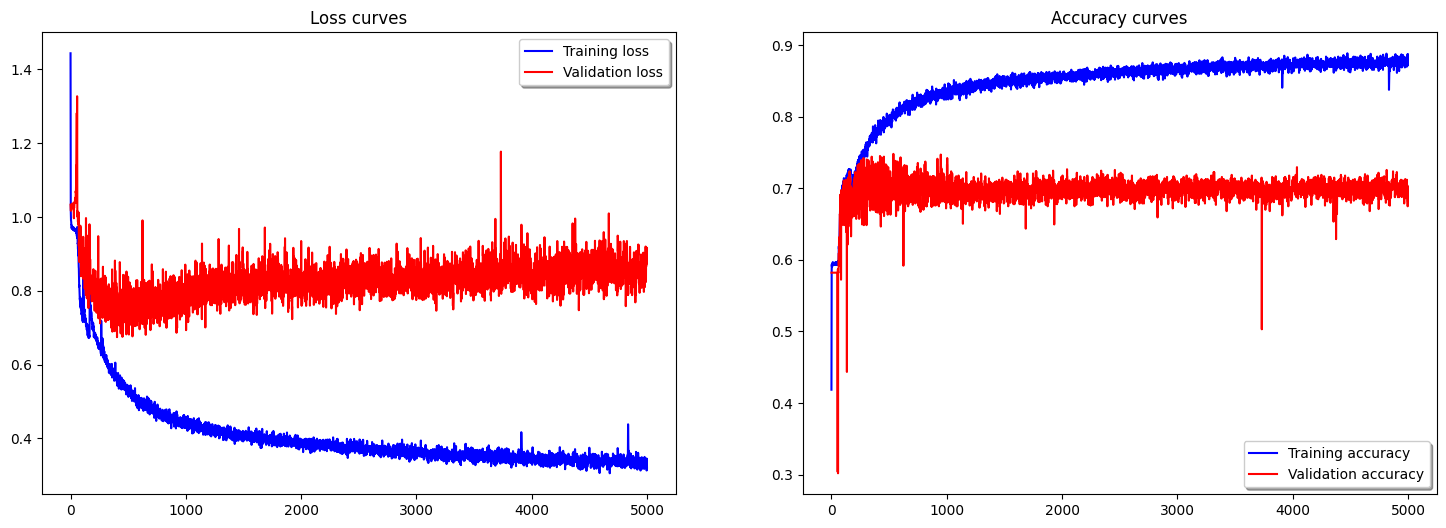

In [ ]:
# Evaluate the model:
train_loss, train_accuracy = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=M_TRAIN,
                                       verbose=1)

test_loss, test_accuracy = model.evaluate(X_val[:M_TEST],
                                     y_val[:M_TEST],
                                     batch_size=M_TEST,
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
# Build the Model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(T,1)))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=13, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=15, activation='relu'))
model.add(Dropout(dropout_CNN))
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=4, activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],#, AUC()],#[f1_score],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1,
                             verbose=0, 
                             factor=0.5,
                             min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0, 
                           patience=100000,
                           verbose=1,
                           mode='auto',
                           baseline=0,
                           restore_best_weights=True)

In [ ]:
start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=5000,
                    batch_size=X_train_partial.shape[0],
                    validation_split=0.0,
                    validation_data=(X_val[:M_TEST], y_val[:M_TEST]),
                    shuffle=True,
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

In [ ]:
# Evaluate the model:
train_loss, train_accuracy, train_auc = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=M_TRAIN,
                                       verbose=1)

test_loss, test_accuracy, test_auc = model.evaluate(X_val[:M_TEST],
                                     y_val[:M_TEST],
                                     batch_size=M_TEST,
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')
print(f'train AUC = {round(train_auc, 4)}')
print(f'test AUC = {round(test_auc, 4)}')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

1/1 [==============================] - 0s 367ms/step - loss: 0.6085 - accuracy: 0.7393


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
y_pred = model.predict(X_val)
f1_score(y_val, to_categorical(y_pred.argmax(axis=1)), average='micro')

22/22 [==============================] - 0s 11ms/step


0.6974063400576369

In [ ]:
(y_pred>.6).any(axis=1).sum() / y_pred.shape[0]

0.9596541786743515

<Axes: >

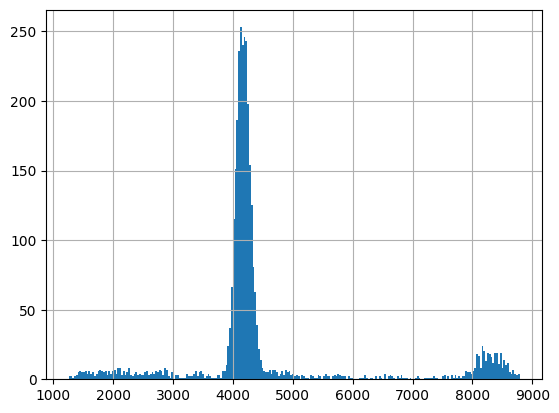

In [ ]:
measure_length_test = (-X_test.T.isna()).sum().sort_values(ascending=True)
measure_length_test.hist(bins=250)

In [ ]:
n_timesteps, n_features, n_outputs = X_train_partial.shape[1], 1, 3

# head 1
inputs1 = Input(shape=(n_timesteps, n_features))
conv1 = MaxPooling1D(pool_size=3)(Dropout(dropout_CNN)(Conv1D(filters=8, kernel_size=3, activation='relu')(inputs1)))
conv2 = MaxPooling1D(pool_size=3)(Dropout(dropout_CNN)(Conv1D(filters=8, kernel_size=5, activation='relu')(conv1)))
conv3 = MaxPooling1D(pool_size=3)(Dropout(dropout_CNN)(Conv1D(filters=8, kernel_size=7, activation='relu')(conv2)))
flat1 = Flatten()(conv3)
# head 2
inputs2 = Input(shape=(n_timesteps, n_features))
conv4 = MaxPooling1D(pool_size=3)(Dropout(dropout_CNN)(Conv1D(filters=32, kernel_size=31, activation='relu')(inputs2)))
conv5 = MaxPooling1D(pool_size=3)(Dropout(dropout_CNN)(Conv1D(filters=32, kernel_size=51, activation='relu')(conv4)))
conv6 = MaxPooling1D(pool_size=3)(Dropout(dropout_CNN)(Conv1D(filters=32, kernel_size=71, activation='relu')(conv5)))
flat2 = Flatten()(conv6)
# merge
merged = tf.keras.layers.concatenate([flat1, flat2])
# interpretation
dense1 = Dense(32, activation='relu')(merged)
batchnorm1 = BatchNormalization()(dense1)
drop4 = Dropout(dropout)(batchnorm1)
dense2 = Dense(32, activation='relu')(drop4)
batchnorm2 = BatchNormalization()(dense2)
drop5 = Dropout(dropout)(batchnorm2)
dense3 = Dense(32, activation='relu')(drop5)
batchnorm3 = BatchNormalization()(dense3)
drop6 = Dropout(dropout)(batchnorm3)
dense4 = Dense(16, activation='relu')(drop6)
batchnorm4 = BatchNormalization()(dense4)
outputs = Dense(n_outputs, activation='softmax')(batchnorm4)
model = tf.keras.Model(inputs=[inputs1, inputs2], outputs=outputs)

# save a plot of the model
tf.keras.utils.plot_model(model, show_shapes=True, to_file='multichannel.png')
# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy', AUC()],#[f1_score],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
print(model.summary())

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 1252, 1)]            0         []                            
                                                                                                  
 input_32 (InputLayer)       [(None, 1252, 1)]            0         []                            
                                                                                                  
 conv1d_78 (Conv1D)          (None, 1250, 8)              32        ['input_31[0][0]']            
                                                                                                  
 conv1d_81 (Conv1D)          (None, 1222,

Epoch 1/150
1/1 [==============================] - 2s 2s/step - loss: 1.2362 - accuracy: 0.3665 - auc_7: 0.5230 - val_loss: 1.3509 - val_accuracy: 0.1282 - val_auc_7: 0.3587
Epoch 2/150
1/1 [==============================] - 1s 1s/step - loss: 1.2014 - accuracy: 0.3835 - auc_7: 0.5345 - val_loss: 1.1587 - val_accuracy: 0.4222 - val_auc_7: 0.5611
Epoch 3/150
1/1 [==============================] - 1s 1s/step - loss: 1.1675 - accuracy: 0.3799 - auc_7: 0.5352 - val_loss: 2.0675 - val_accuracy: 0.4294 - val_auc_7: 0.5230
Epoch 4/150
1/1 [==============================] - 1s 1s/step - loss: 1.1283 - accuracy: 0.3936 - auc_7: 0.5535 - val_loss: 2.6659 - val_accuracy: 0.4294 - val_auc_7: 0.5928
Epoch 5/150
1/1 [==============================] - 2s 2s/step - loss: 1.1189 - accuracy: 0.3994 - auc_7: 0.5585 - val_loss: 3.1938 - val_accuracy: 0.4294 - val_auc_7: 0.5698
Epoch 6/150
1/1 [==============================] - 1s 1s/step - loss: 1.1123 - accuracy: 0.4026 - auc_7: 0.5658 - val_loss: 2.3433

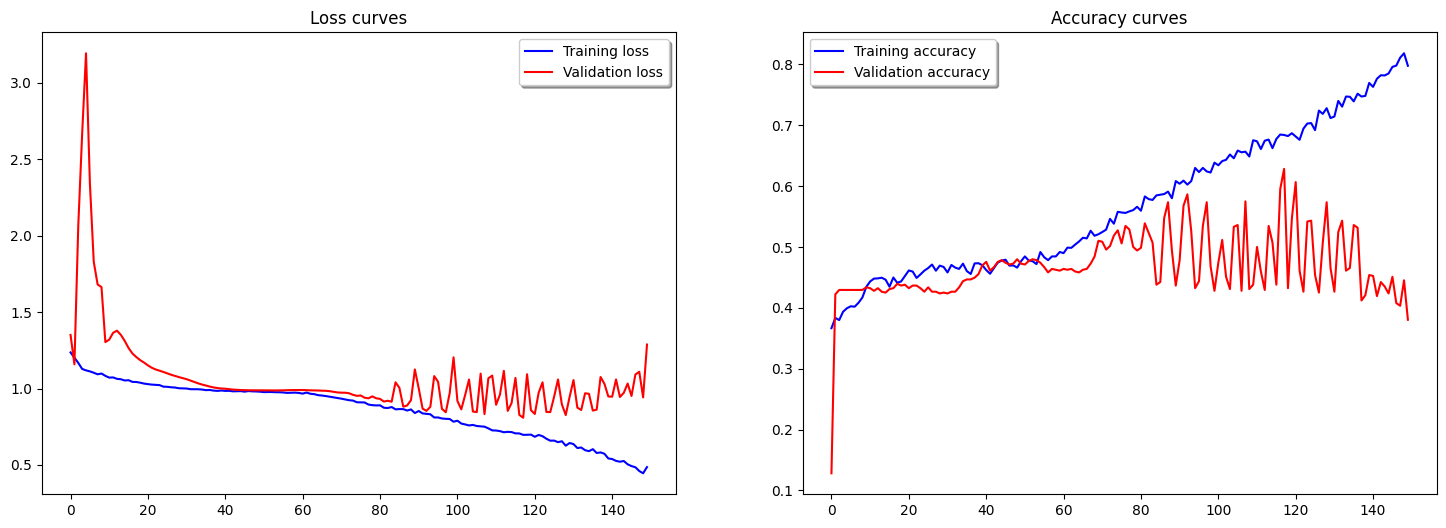

In [ ]:
start = time.time()
History = model.fit([X_train_partial, X_train_partial],
                    y_train_partial,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=([X_val[:M_TEST], X_val[:M_TEST]], y_val[:M_TEST]),
                    shuffle=True,
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

# Evaluate the model:
train_loss, train_accuracy, train_auc = model.evaluate([X_train_partial, X_train_partial],
                                       y_train_partial,
                                       batch_size=M_TRAIN,
                                       verbose=1)

test_loss, test_accuracy, test_auc = model.evaluate([X_val[:M_TEST], X_val[:M_TEST]],
                                     y_val[:M_TEST],
                                     batch_size=M_TEST,
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')
print(f'train AUC = {round(train_auc, 4)}')
print(f'test AUC = {round(test_auc, 4)}')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()


In [ ]:
# Build the Model
model = Sequential()
model.add(Conv1D(filters=48, kernel_size=3, activation='relu', input_shape=(T,1)))
model.add(Dropout(.4))
model.add(Conv1D(filters=48, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=32, kernel_size=7, activation='relu'))
model.add(Dropout(.4))
model.add(Conv1D(filters=32, kernel_size=9, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(filters=16, kernel_size=15, activation='relu'))
model.add(Dropout(.4))
model.add(Conv1D(filters=16, kernel_size=21, activation='relu'))
model.add(Dropout(.4))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=3, activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy', AUC()],#[f1_score],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
print(model.summary())

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_95 (Conv1D)          (None, 1250, 48)          192       
                                                                 
 dropout_156 (Dropout)       (None, 1250, 48)          0         
                                                                 
 conv1d_96 (Conv1D)          (None, 1246, 48)          11568     
                                                                 
 max_pooling1d_52 (MaxPooli  (None, 415, 48)           0         
 ng1D)                                                           
                                                                 
 conv1d_97 (Conv1D)          (None, 409, 32)           10784     
                                                                 
 dropout_157 (Dropout)       (None, 409, 32)           0         
                                                     

In [ ]:
start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_val[:M_TEST], y_val[:M_TEST]),
                    shuffle=True,
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

Epoch 1/150


1/1 [==============================] - 3s 3s/step - loss: 1.6229 - accuracy: 0.3160 - auc_21: 0.4860 - val_loss: 1.1270 - val_accuracy: 0.3329 - val_auc_21: 0.4417
Epoch 2/150
1/1 [==============================] - 2s 2s/step - loss: 1.4662 - accuracy: 0.3420 - auc_21: 0.5141 - val_loss: 1.1432 - val_accuracy: 0.3386 - val_auc_21: 0.4513
Epoch 3/150
1/1 [==============================] - 2s 2s/step - loss: 1.4285 - accuracy: 0.3366 - auc_21: 0.5104 - val_loss: 1.2204 - val_accuracy: 0.3271 - val_auc_21: 0.4401
Epoch 4/150
1/1 [==============================] - 2s 2s/step - loss: 1.3505 - accuracy: 0.3369 - auc_21: 0.5186 - val_loss: 1.2962 - val_accuracy: 0.3444 - val_auc_21: 0.4501
Epoch 5/150
1/1 [==============================] - 2s 2s/step - loss: 1.2960 - accuracy: 0.3521 - auc_21: 0.5289 - val_loss: 1.3662 - val_accuracy: 0.3991 - val_auc_21: 0.4878
Epoch 6/150
1/1 [==============================] - 2s 2s/step - loss: 1.2469 - accuracy: 0.3629 - auc_21: 0.5496 - val_loss: 1.5187 

1/1 [==============================] - 0s 104ms/step - loss: 0.8701 - accuracy: 0.6182 - auc_21: 0.8027
-----------------------------------------------------------------
train accuracy = 67.5325%
test accuracy = 61.8156%
train AUC = 0.8511
test AUC = 0.8027


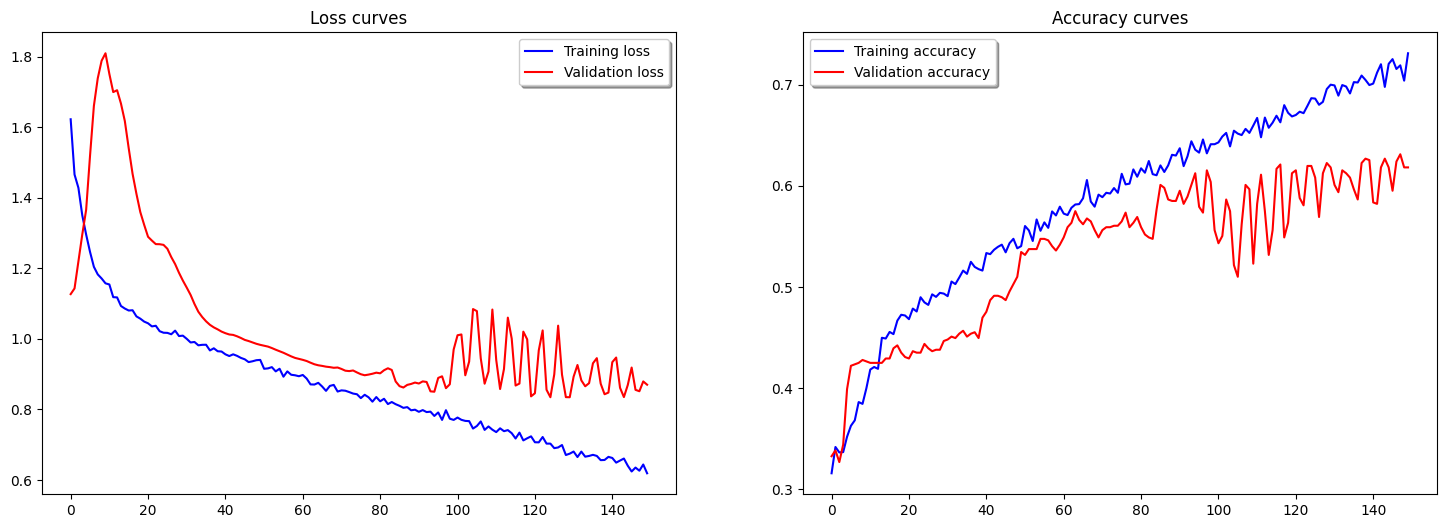

In [ ]:
# Evaluate the model:
train_loss, train_accuracy, train_auc = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=M_TRAIN,
                                       verbose=1)

test_loss, test_accuracy, test_auc = model.evaluate(X_val[:M_TEST],
                                     y_val[:M_TEST],
                                     batch_size=M_TEST,
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')
print(f'train AUC = {round(train_auc, 4)}')
print(f'test AUC = {round(test_auc, 4)}')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

1/1 [==============================] - 0s 88ms/step - loss: 1.4278 - accuracy: 0.5274 - auc_12: 0.6535
-----------------------------------------------------------------
train accuracy = 86.2554%
test accuracy = 52.7378%
train AUC = 0.9703
test AUC = 0.6535


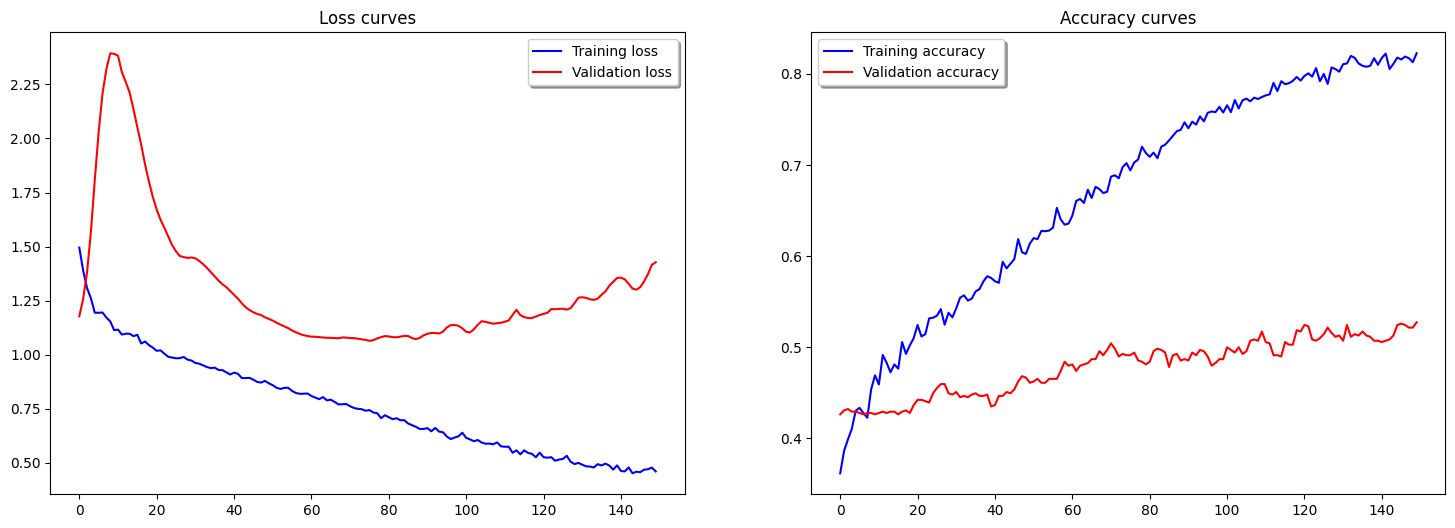

In [ ]:
# Evaluate the model:
train_loss, train_accuracy, train_auc = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=M_TRAIN,
                                       verbose=1)

test_loss, test_accuracy, test_auc = model.evaluate(X_val[:M_TEST],
                                     y_val[:M_TEST],
                                     batch_size=M_TEST,
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')
print(f'train AUC = {round(train_auc, 4)}')
print(f'test AUC = {round(test_auc, 4)}')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [ ]:
T = X_train_partial.shape[1]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [32, 16, 24, 24, 16, 8, 3]                # number of units in hidden and output layers
M_TRAIN = X_train_partial.shape[0]           # number of training examples (2D)
M_TEST = X_val.shape[0]             # number of test examples (2D),full=X_test.shape[0]
BATCH = M_TRAIN# // 8                          # batch size
EPOCH = 150                          # number of epochs
learning_rate = 5e-3                            # learning rate of the gradient descent
LAMBD = 3e-3                         # lambda in L2 regularizaion
dropout = 0.15                             # dropout rate
recurrent_dropout = 0.0                            # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, val_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {1}, epochs = {EPOCH}')
print(f'learning_rate = {learning_rate}, lambda = {LAMBD}, dropout = {dropout}, recurrent_dropout = {recurrent_dropout}')

layers=[32, 16, 24, 24, 16, 8, 3], train_examples=2772, val_examples=694
batch = 2772, timesteps = 1252, features = 1, epochs = 150
learning_rate = 0.005, lambda = 0.003, dropout = 0.15, recurrent_dropout = 0.0


import tensorflow as tf
from keras import backend as K

def f1_score(y_true, y_pred):
    # Calculating the Precision and Recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # Calculating F1 Score
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(T,1),
               units=LAYERS[0],
               activation='tanh',
               recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD),
               recurrent_regularizer=l2(LAMBD),
               dropout=dropout,
               recurrent_dropout=recurrent_dropout,
               return_sequences=True,
               return_state=False,
               stateful=False,
               unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh',
               recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD),
               recurrent_regularizer=l2(LAMBD),
               dropout=dropout,
               recurrent_dropout=recurrent_dropout,
               return_sequences=False,
               return_state=False,
               stateful=False,
               unroll=False
              ))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=LAYERS[2], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=LAYERS[3], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=LAYERS[4], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=LAYERS[5], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))
model.add(Dense(units=LAYERS[-1], activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy', AUC()],#[f1_score],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
print(model.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1,
                             verbose=0, 
                             factor=0.5,
                             min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0, 
                           patience=100,
                           verbose=1,
                           mode='auto',
                           baseline=0,
                           restore_best_weights=True)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 1252, 32)          4352      
                                                                 
 batch_normalization_35 (Ba  (None, 1252, 32)          128       
 tchNormalization)                                               
                                                                 
 lstm_20 (LSTM)              (None, 16)                3136      
                                                                 
 batch_normalization_36 (Ba  (None, 16)                64        
 tchNormalization)                                               
                                                                 
 dropout_14 (Dropout)        (None, 16)                0         
                                                                 
 dense_33 (Dense)            (None, 24)               

In [ ]:
start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_val[:M_TEST], y_val[:M_TEST]),
                    shuffle=True,
                    verbose=1,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=M_TRAIN,
                                       verbose=1)

test_loss, test_acc = model.evaluate(X_val[:M_TEST],
                                     y_val[:M_TEST],
                                     batch_size=M_TEST,
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

Epoch 1/150


1/1 [==============================] - 10s 10s/step - loss: 1.8968 - accuracy: 0.3099 - auc_8: 0.4880 - val_loss: 1.3685 - val_accuracy: 0.4424 - val_auc_8: 0.6428 - lr: 0.0050
Epoch 2/150
1/1 [==============================] - 8s 8s/step - loss: 1.7975 - accuracy: 0.3222 - auc_8: 0.5029 - val_loss: 1.3568 - val_accuracy: 0.4582 - val_auc_8: 0.6557 - lr: 0.0050
Epoch 3/150
1/1 [==============================] - 8s 8s/step - loss: 1.7202 - accuracy: 0.3308 - auc_8: 0.4986 - val_loss: 1.3459 - val_accuracy: 0.4539 - val_auc_8: 0.6554 - lr: 0.0050
Epoch 4/150
1/1 [==============================] - 8s 8s/step - loss: 1.6737 - accuracy: 0.3279 - auc_8: 0.5025 - val_loss: 1.3354 - val_accuracy: 0.4496 - val_auc_8: 0.6620 - lr: 0.0050
Epoch 5/150
1/1 [==============================] - 9s 9s/step - loss: 1.6068 - accuracy: 0.3398 - auc_8: 0.5146 - val_loss: 1.3251 - val_accuracy: 0.4481 - val_auc_8: 0.6646 - lr: 0.0050
Epoch 6/150
1/1 [==============================] - 9s 9s/step - loss: 1.600

InvalidParameterError: The 'y_pred' parameter of f1_score must be an array-like or a sparse matrix. Got 587 instead.

In [ ]:
y_pred = to_categorical(model.predict(X_val).argmax(axis=1))
y_pred

22/22 [==============================] - 1s 53ms/step


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
f1_score(y_val, y_pred, average='micro')

0.45821325648414984

Epoch 1/50
9/9 [==============================] - 45s 5s/step - loss: 3.8726 - accuracy: 0.3911 - val_loss: 4.0207 - val_accuracy: 0.5898 - lr: 0.0500
Epoch 2/50
9/9 [==============================] - 41s 5s/step - loss: 2.8266 - accuracy: 0.5616 - val_loss: 29.1877 - val_accuracy: 0.2754 - lr: 0.0500
Epoch 3/50
9/9 [==============================] - 40s 4s/step - loss: 2.6621 - accuracy: 0.5236 - val_loss: 6.7147 - val_accuracy: 0.5898 - lr: 0.0500
Epoch 4/50
9/9 [==============================] - 40s 4s/step - loss: 2.1578 - accuracy: 0.5453 - val_loss: 2.7816 - val_accuracy: 0.2852 - lr: 0.0500
Epoch 5/50
9/9 [==============================] - 43s 5s/step - loss: 2.2244 - accuracy: 0.5081 - val_loss: 3.0780 - val_accuracy: 0.5508 - lr: 0.0500
Epoch 6/50
9/9 [==============================] - 42s 5s/step - loss: 2.4330 - accuracy: 0.5077 - val_loss: 2.6616 - val_accuracy: 0.5898 - lr: 0.0250
Epoch 7/50
9/9 [==============================] - 43s 5s/step - loss: 2.0176 - accuracy: 0.54

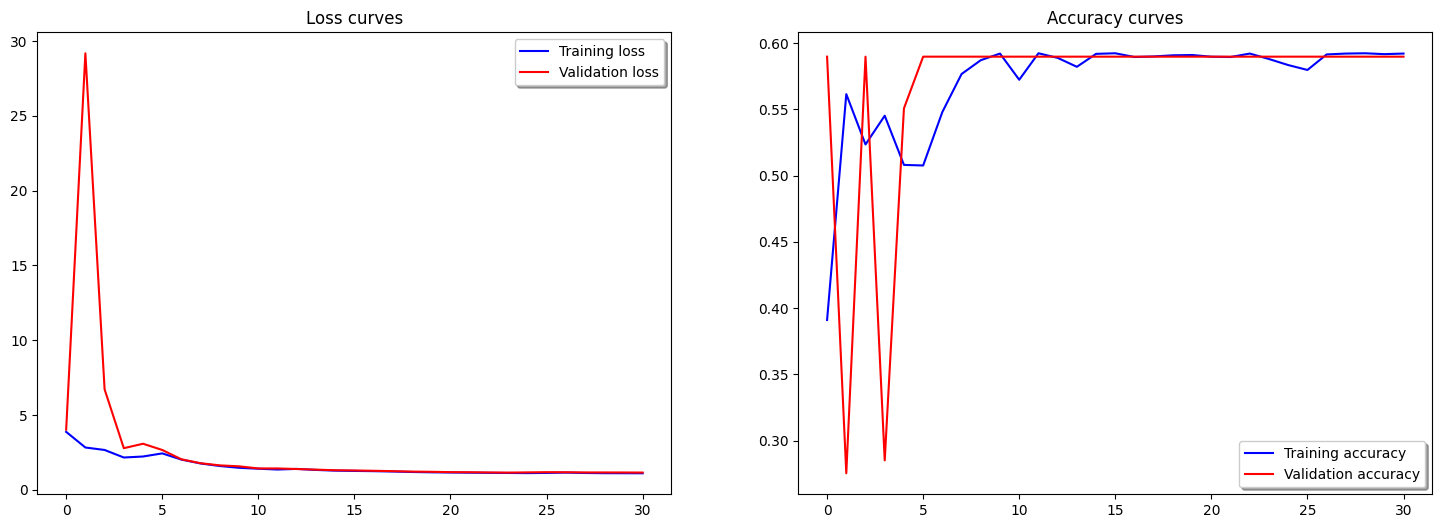

In [ ]:
start = time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_val[:M_TEST], y_val[:M_TEST]),
                    shuffle=True,
                    verbose=1,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=M_TRAIN,
                                       verbose=1)

test_loss, test_acc = model.evaluate(X_val[:M_TEST],
                                     y_val[:M_TEST],
                                     batch_size=M_TEST,
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

Epoch 1/50
1/1 [==============================] - 89s 89s/step - loss: 13.7989 - accuracy: 0.2289 - val_loss: 9.7192 - val_accuracy: 0.4062 - lr: 0.0500
Epoch 2/50
1/1 [==============================] - 87s 87s/step - loss: 10.0856 - accuracy: 0.2743 - val_loss: 9.0830 - val_accuracy: 0.4219 - lr: 0.0500
Epoch 3/50
1/1 [==============================] - 86s 86s/step - loss: 9.3113 - accuracy: 0.3442 - val_loss: 9.3445 - val_accuracy: 0.5898 - lr: 0.0500
Epoch 4/50
1/1 [==============================] - 85s 85s/step - loss: 9.4037 - accuracy: 0.4882 - val_loss: 9.6723 - val_accuracy: 0.5898 - lr: 0.0500
Epoch 5/50
1/1 [==============================] - 86s 86s/step - loss: 9.6852 - accuracy: 0.5431 - val_loss: 9.3801 - val_accuracy: 0.5898 - lr: 0.0250
Epoch 6/50
1/1 [==============================] - 84s 84s/step - loss: 9.4050 - accuracy: 0.5874 - val_loss: 8.9714 - val_accuracy: 0.5898 - lr: 0.0125
Epoch 7/50
1/1 [==============================] - 84s 84s/step - loss: 9.0023 - accura

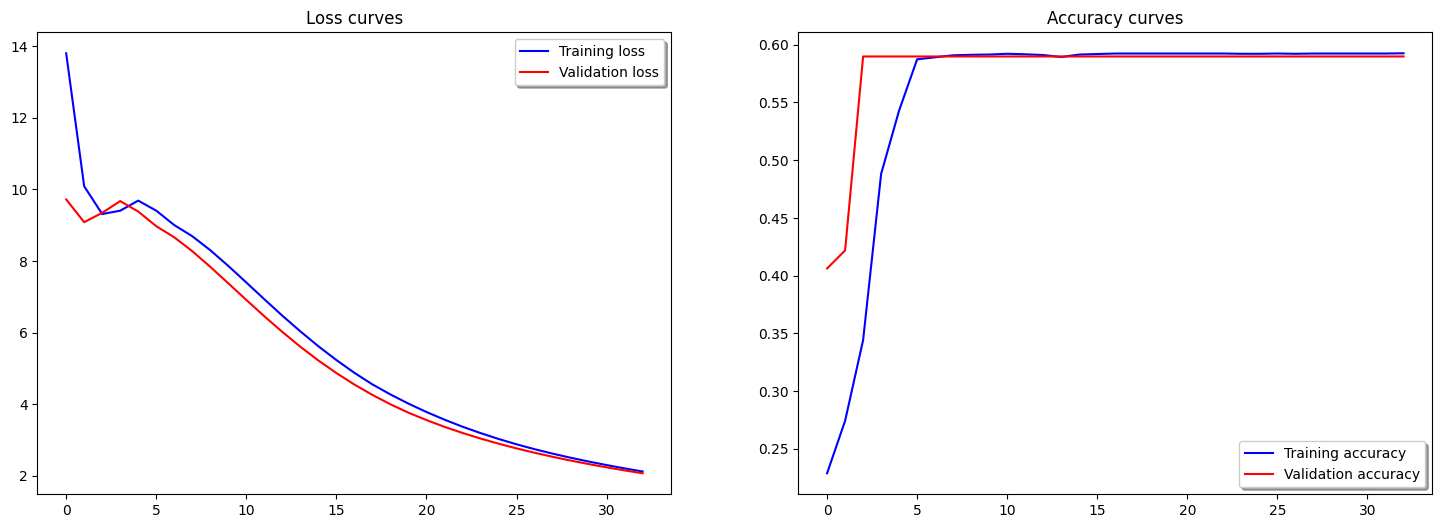

In [ ]:
start = time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.0,
                    validation_data=(X_val[:M_TEST], y_val[:M_TEST]),
                    shuffle=True,
                    verbose=1,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=M_TRAIN,
                                       verbose=1)

test_loss, test_acc = model.evaluate(X_val[:M_TEST],
                                     y_val[:M_TEST],
                                     batch_size=M_TEST,
                                     verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

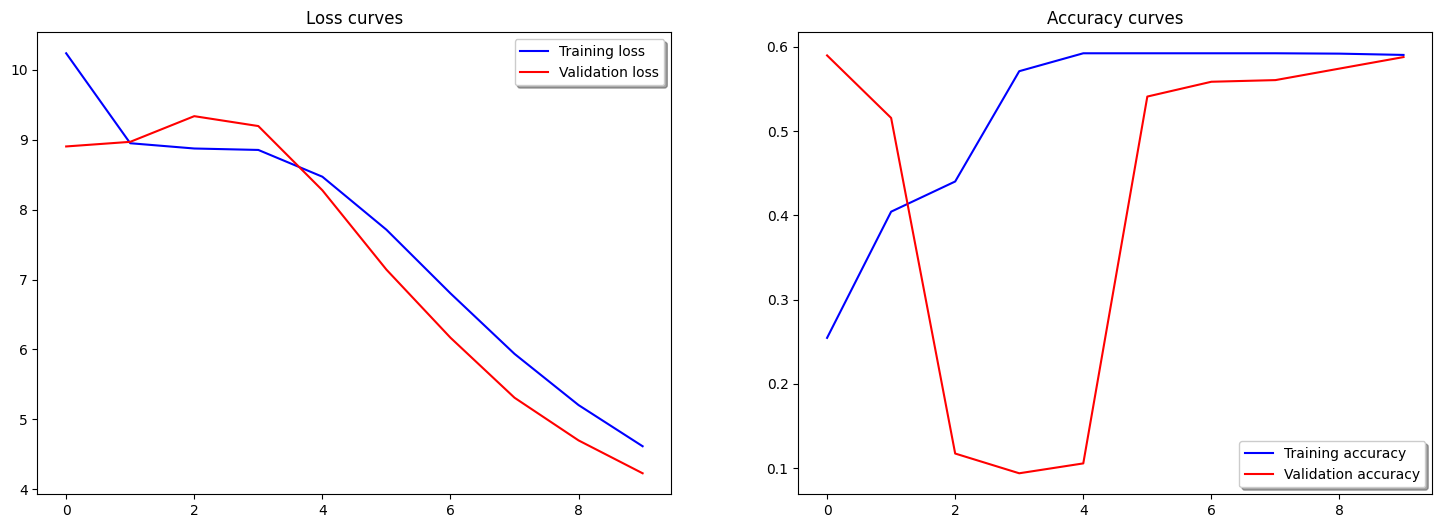